In [1]:
import numpy
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
torch.manual_seed(42)

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:

path = '/content/drive/My Drive/Dataset/FMNIST/fashion-mnist_train.csv'
df = pd.read_csv(path)
dftest = pd.read_csv('/content/drive/My Drive/Dataset/FMNIST/fashion-mnist_test.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


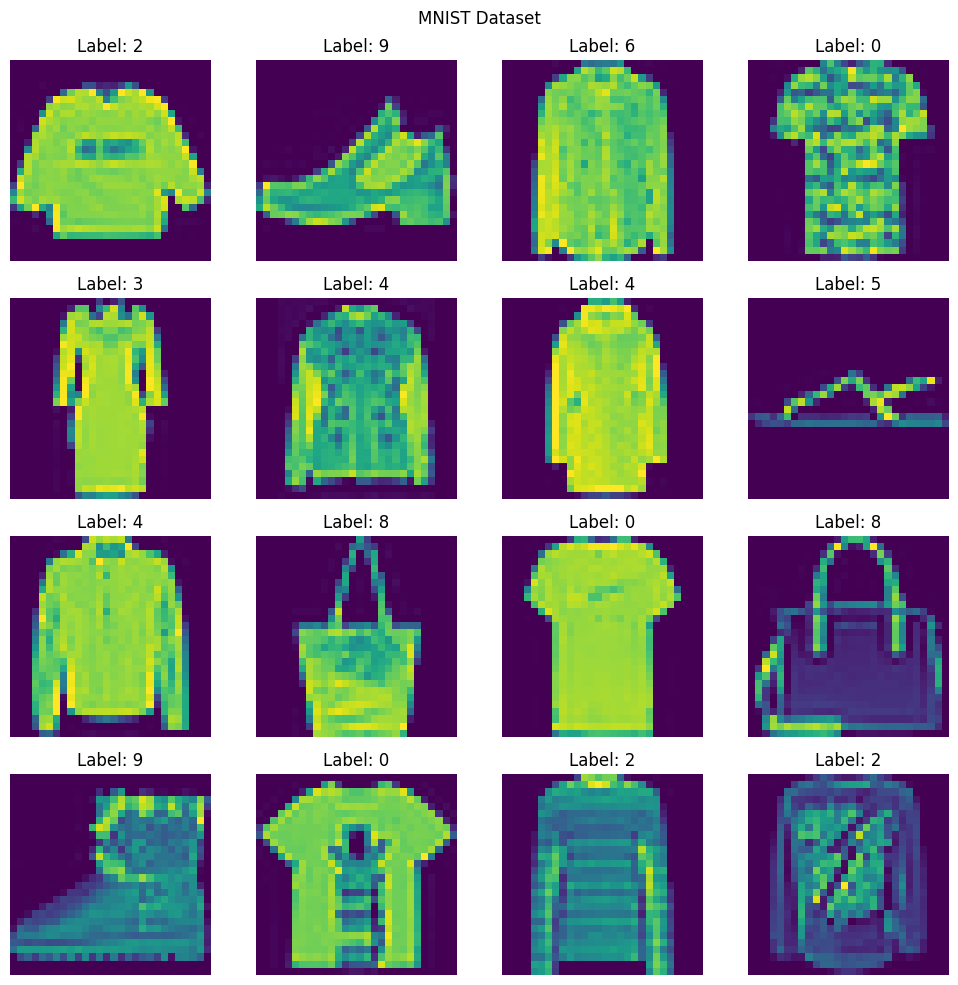

In [5]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("MNIST Dataset")

for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label: {df.iloc[i,0]}")
plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [6]:
X=df.iloc[:,1:]
Y=df.iloc[:,0]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [7]:
X_train/=255.0
X_test/=255.0


X_actualtest=dftest.iloc[:,1:]
X_actualtest/=255.0
Y_actualtest=dftest.iloc[:,0]

In [8]:
class Custom_Dataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [9]:
testdataset=Custom_Dataset(X_test.values,Y_test.values)
traindataset=Custom_Dataset(X_train.values,Y_train.values)

In [10]:
class MyNN(nn.Module):
  def __init__(self,no_convs,input_features,conv_channels,kernel_sizes,pool_sizes,num_hidden_layers,n_layer,dropout_rate,out_dim):
    super().__init__()


    conv_layers=[]
    input_feature=input_features
    for i in range(no_convs):
      output_feature = conv_channels[i]
      kernel_size = kernel_sizes[i]
      pool_size = pool_sizes[i]
      conv_layers.extend([
      nn.Conv2d(input_feature,output_feature,kernel_size,stride=1,padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(output_feature),
      nn.MaxPool2d(pool_size,stride=2),
        ])
      input_feature = output_feature


    self.features=nn.Sequential(*conv_layers)
    with torch.no_grad():
        dummy = torch.zeros(1, input_features, 28, 28)
        out = self.features(dummy)
        flatten_dim = out.view(1, -1).size(1)





    input_dim=flatten_dim
    layer=[]
    for i in range(num_hidden_layers):
      layer.append(nn.Linear(input_dim,n_layer))
      layer.append(nn.BatchNorm1d(n_layer))
      layer.append(nn.ReLU())
      layer.append(nn.Dropout(dropout_rate))
      input_dim=n_layer
    layer.append(nn.Linear(n_layer,out_dim))
    self.classifier=nn.Sequential(*layer)





  def forward(self,x):
    x = x.view(-1, 1, 28, 28) # Reshape the input
    x=self.features(x)
    x = torch.flatten(x, 1)
    x=self.classifier(x)

    return x

In [11]:
def objective(trial):
    no_convs = trial.suggest_int("no_convs", 1, 3)
    conv_channels = [trial.suggest_int(f"conv_channels_{i}", 16, 64) for i in range(no_convs)]
    kernel_sizes = [trial.suggest_int(f"kernel_size_{i}", 3, 5) for i in range(no_convs)]
    pool_sizes = [trial.suggest_int(f"pool_size_{i}", 2, 2) for i in range(no_convs)]
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    n_layer = trial.suggest_int("n_layer", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learnrate = trial.suggest_float("learnrate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    epochs = trial.suggest_int("epochs", 10, 60)
    batch_size = trial.suggest_int("batch_size", 16, 128)
    input_features = 1
    out_dim = 10


    model = MyNN(
        no_convs=no_convs,
        input_features=input_features,
        conv_channels=conv_channels,
        kernel_sizes=kernel_sizes,
        pool_sizes=pool_sizes,
        num_hidden_layers=num_hidden_layers,
        n_layer=n_layer,
        dropout_rate=dropout_rate,
        out_dim=out_dim,
    )
    model = model.to(device)

    # Loss function and optimizer
    lossFN = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learnrate, weight_decay=weight_decay)


    train_loader=DataLoader(traindataset,batch_size=batch_size,shuffle=True,pin_memory=True)
    test_loader=DataLoader(testdataset,batch_size=batch_size,shuffle=False,pin_memory=True)


    # Training loop
    for epoch in range(epochs):
        model.train()
        Cost = 0
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            loss = lossFN(outputs, batch_labels)
            Cost += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Cost /= len(train_loader)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Cost {Cost}")

    # Evaluation
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy}")

    return accuracy

In [12]:
!pip install optuna
import optuna
study= optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.2 MB/s eta 0:00:00


[I 2025-10-10 22:25:29,407] A new study created in memory with name: no-name-2adb3c8b-ccd8-4512-8855-61b5bee7db3f
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


Epoch 0: Cost 0.4805505278566438
Epoch 5: Cost 0.30170432390145757
Epoch 10: Cost 0.28334333831882236


[I 2025-10-10 22:26:29,023] Trial 0 finished with value: 0.9053333333333333 and parameters: {'no_convs': 3, 'conv_channels_0': 48, 'conv_channels_1': 64, 'conv_channels_2': 20, 'kernel_size_0': 5, 'kernel_size_1': 4, 'kernel_size_2': 5, 'pool_size_0': 2, 'pool_size_1': 2, 'pool_size_2': 2, 'num_hidden_layers': 2, 'n_layer': 45, 'dropout_rate': 0.14090259532167493, 'learnrate': 0.0033169252720422243, 'weight_decay': 0.0009405647092888362, 'epochs': 13, 'batch_size': 61}. Best is trial 0 with value: 0.9053333333333333.


Validation Accuracy: 0.9053333333333333
Epoch 0: Cost 0.5317535036609831
Epoch 5: Cost 0.2834006102642668
Epoch 10: Cost 0.25868338791912315
Epoch 15: Cost 0.249730842126034
Epoch 20: Cost 0.2386258978126917


[I 2025-10-10 22:28:03,384] Trial 1 finished with value: 0.9154166666666667 and parameters: {'no_convs': 3, 'conv_channels_0': 44, 'conv_channels_1': 42, 'conv_channels_2': 21, 'kernel_size_0': 3, 'kernel_size_1': 5, 'kernel_size_2': 3, 'pool_size_0': 2, 'pool_size_1': 2, 'pool_size_2': 2, 'num_hidden_layers': 1, 'n_layer': 90, 'dropout_rate': 0.30236227553831685, 'learnrate': 0.0005069352792878282, 'weight_decay': 0.008327925931508839, 'epochs': 21, 'batch_size': 47}. Best is trial 1 with value: 0.9154166666666667.


Validation Accuracy: 0.9154166666666667
Epoch 0: Cost 1.2576095626687922
Epoch 5: Cost 0.3459962504659897
Epoch 10: Cost 0.26702493030898283
Epoch 15: Cost 0.2278394936937305
Epoch 20: Cost 0.19667296340880666
Epoch 25: Cost 0.17817985831208616
Epoch 30: Cost 0.1610546184556078
Epoch 35: Cost 0.14520528070113511
Epoch 40: Cost 0.13614127151730893


[I 2025-10-10 22:30:25,674] Trial 2 finished with value: 0.9080833333333334 and parameters: {'no_convs': 3, 'conv_channels_0': 36, 'conv_channels_1': 23, 'conv_channels_2': 19, 'kernel_size_0': 4, 'kernel_size_1': 3, 'kernel_size_2': 4, 'pool_size_0': 2, 'pool_size_1': 2, 'pool_size_2': 2, 'num_hidden_layers': 2, 'n_layer': 86, 'dropout_rate': 0.3330779768115413, 'learnrate': 0.00011680268970651953, 'weight_decay': 0.00042208410979244226, 'epochs': 42, 'batch_size': 81}. Best is trial 1 with value: 0.9154166666666667.


Validation Accuracy: 0.9080833333333334
Epoch 0: Cost 1.184977685336284
Epoch 5: Cost 0.42693696934220277
Epoch 10: Cost 0.36673982518422205
Epoch 15: Cost 0.34280341902130645
Epoch 20: Cost 0.3281997684219507
Epoch 25: Cost 0.3174825892033548
Epoch 30: Cost 0.3043631472508777
Epoch 35: Cost 0.299983315928457
Epoch 40: Cost 0.29546571092674434
Epoch 45: Cost 0.29279394992443203


[I 2025-10-10 22:33:38,799] Trial 3 finished with value: 0.90625 and parameters: {'no_convs': 2, 'conv_channels_0': 46, 'conv_channels_1': 23, 'kernel_size_0': 4, 'kernel_size_1': 4, 'pool_size_0': 2, 'pool_size_1': 2, 'num_hidden_layers': 3, 'n_layer': 36, 'dropout_rate': 0.31933139292610707, 'learnrate': 0.00040081413164331516, 'weight_decay': 0.0049871010144517565, 'epochs': 49, 'batch_size': 73}. Best is trial 1 with value: 0.9154166666666667.


Validation Accuracy: 0.90625
Epoch 0: Cost 1.527803897880015
Epoch 5: Cost 0.6792350255754676
Epoch 10: Cost 0.5822671897538959
Epoch 15: Cost 0.539054775197809
Epoch 20: Cost 0.517589214182119
Epoch 25: Cost 0.4943705229364534
Epoch 30: Cost 0.4777849337304682
Epoch 35: Cost 0.4574513453326737


[I 2025-10-10 22:41:04,471] Trial 4 finished with value: 0.9186666666666666 and parameters: {'no_convs': 2, 'conv_channels_0': 17, 'conv_channels_1': 41, 'kernel_size_0': 3, 'kernel_size_1': 4, 'pool_size_0': 2, 'pool_size_1': 2, 'num_hidden_layers': 3, 'n_layer': 36, 'dropout_rate': 0.43529521839557694, 'learnrate': 0.00020171119428420597, 'weight_decay': 5.4983232554820146e-05, 'epochs': 40, 'batch_size': 18}. Best is trial 4 with value: 0.9186666666666666.


Validation Accuracy: 0.9186666666666666
Epoch 0: Cost 0.5267733233307981
Epoch 5: Cost 0.23210216340281223
Epoch 10: Cost 0.18766819989690584
Epoch 15: Cost 0.16561272911954214
Epoch 20: Cost 0.15300368469278516
Epoch 25: Cost 0.13958291839574768
Epoch 30: Cost 0.13270398098958744
Epoch 35: Cost 0.12831078484010755
Epoch 40: Cost 0.12441594523461927
Epoch 45: Cost 0.11928227671481262


[I 2025-10-10 22:45:16,469] Trial 5 finished with value: 0.925 and parameters: {'no_convs': 2, 'conv_channels_0': 30, 'conv_channels_1': 50, 'kernel_size_0': 3, 'kernel_size_1': 4, 'pool_size_0': 2, 'pool_size_1': 2, 'num_hidden_layers': 3, 'n_layer': 101, 'dropout_rate': 0.312516596075442, 'learnrate': 0.0009910923438815737, 'weight_decay': 0.0002464037290977692, 'epochs': 47, 'batch_size': 43}. Best is trial 5 with value: 0.925.


Validation Accuracy: 0.925
Epoch 0: Cost 0.37180381613797037
Epoch 5: Cost 0.19412573682513215
Epoch 10: Cost 0.16361258489390215


[I 2025-10-10 22:45:54,027] Trial 6 finished with value: 0.9101666666666667 and parameters: {'no_convs': 2, 'conv_channels_0': 36, 'conv_channels_1': 59, 'kernel_size_0': 5, 'kernel_size_1': 4, 'pool_size_0': 2, 'pool_size_1': 2, 'num_hidden_layers': 1, 'n_layer': 108, 'dropout_rate': 0.21117113039716334, 'learnrate': 0.003821373288581711, 'weight_decay': 0.00012669810348721564, 'epochs': 14, 'batch_size': 116}. Best is trial 5 with value: 0.925.


Validation Accuracy: 0.9101666666666667
Epoch 0: Cost 0.658594724756976
Epoch 5: Cost 0.22415220895564805
Epoch 10: Cost 0.15649678001106562
Epoch 15: Cost 0.11009546907174324
Epoch 20: Cost 0.08689967436841108
Epoch 25: Cost 0.06962664809559162
Epoch 30: Cost 0.057840601934799146
Epoch 35: Cost 0.05115175193490965
Epoch 40: Cost 0.04513972901415885


[I 2025-10-10 22:54:56,531] Trial 7 finished with value: 0.9181666666666667 and parameters: {'no_convs': 3, 'conv_channels_0': 36, 'conv_channels_1': 53, 'conv_channels_2': 18, 'kernel_size_0': 3, 'kernel_size_1': 5, 'kernel_size_2': 5, 'pool_size_0': 2, 'pool_size_1': 2, 'pool_size_2': 2, 'num_hidden_layers': 2, 'n_layer': 73, 'dropout_rate': 0.18490093601014765, 'learnrate': 0.00018601428777501475, 'weight_decay': 2.755952406752386e-05, 'epochs': 44, 'batch_size': 16}. Best is trial 5 with value: 0.925.


Validation Accuracy: 0.9181666666666667
Epoch 0: Cost 0.5392893768846989
Epoch 5: Cost 0.42244456831365823
Epoch 10: Cost 0.4138889792189002
Epoch 15: Cost 0.411120364330709


[I 2025-10-10 22:55:42,784] Trial 8 finished with value: 0.88925 and parameters: {'no_convs': 1, 'conv_channels_0': 25, 'kernel_size_0': 5, 'pool_size_0': 2, 'num_hidden_layers': 1, 'n_layer': 80, 'dropout_rate': 0.10252934095334543, 'learnrate': 0.00043327434130787897, 'weight_decay': 0.025089877768609055, 'epochs': 16, 'batch_size': 60}. Best is trial 5 with value: 0.925.


Validation Accuracy: 0.88925
Epoch 0: Cost 0.9940720615205
Epoch 5: Cost 0.8001427454491185
Epoch 10: Cost 0.7932845049933211
Epoch 15: Cost 0.7884644826331018
Epoch 20: Cost 0.785334772734726
Epoch 25: Cost 0.7894677112130503
Epoch 30: Cost 0.7832480217029437
Epoch 35: Cost 0.7940567542895413
Epoch 40: Cost 0.7854311193855308


[I 2025-10-10 22:59:12,560] Trial 9 finished with value: 0.8566666666666667 and parameters: {'no_convs': 3, 'conv_channels_0': 37, 'conv_channels_1': 49, 'conv_channels_2': 24, 'kernel_size_0': 4, 'kernel_size_1': 3, 'kernel_size_2': 5, 'pool_size_0': 2, 'pool_size_1': 2, 'pool_size_2': 2, 'num_hidden_layers': 2, 'n_layer': 37, 'dropout_rate': 0.3472406211303093, 'learnrate': 0.0009172856439025317, 'weight_decay': 0.05157469005684505, 'epochs': 42, 'batch_size': 47}. Best is trial 5 with value: 0.925.


Validation Accuracy: 0.8566666666666667


In [13]:
study.best_trial
study.best_params
study.best_value

0.925

In [25]:
best_params = study.best_params

conv_channels = [best_params[f"conv_channels_{i}"] for i in range(best_params["no_convs"])]
kernel_sizes = [best_params[f"kernel_size_{i}"] for i in range(best_params["no_convs"])]
pool_sizes = [best_params[f"pool_size_{i}"] for i in range(best_params["no_convs"])]

model = MyNN(
        no_convs=best_params["no_convs"],
        input_features=1,
        conv_channels=conv_channels,
        kernel_sizes=kernel_sizes,
        pool_sizes=pool_sizes,
        num_hidden_layers=best_params["num_hidden_layers"],
        n_layer=best_params["n_layer"],
        dropout_rate=best_params["dropout_rate"],
        out_dim=10,
    )
model = model.to(device)

    # Loss function and optimizer
lossFN = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["learnrate"], weight_decay=best_params["weight_decay"])


train_loader=DataLoader(traindataset,batch_size=best_params["batch_size"],shuffle=True,pin_memory=True)
test_loader=DataLoader(testdataset,batch_size=best_params["batch_size"],shuffle=False,pin_memory=True)



Epoch 0: Cost 0.3151611230274041
Epoch 5: Cost 0.09636912120506168
Epoch 10: Cost 0.06716950312132637
Epoch 15: Cost 0.06044129875674844
Epoch 20: Cost 0.04191608057357371
Epoch 25: Cost 0.03791878083503495
Epoch 30: Cost 0.04360090877333035
Epoch 35: Cost 0.041628224540812275
Epoch 40: Cost 0.053745836758986115
Epoch 45: Cost 0.051047521660570055
Validation Accuracy after retraining: 0.91


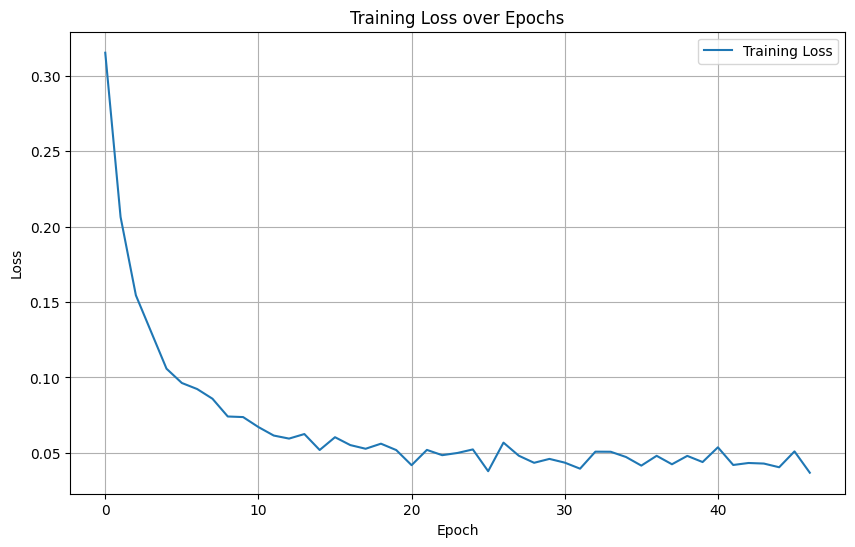

In [38]:
# Training loop
epochs = best_params["epochs"]
train_losses = [] # List to store training loss per epoch

for epoch in range(epochs):
    model.train()
    Cost = 0
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        loss = lossFN(outputs, batch_labels)
        Cost += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Cost /= len(train_loader)
    train_losses.append(Cost) # Store the cost for this epoch
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Cost {Cost}")

# Evaluation on the test set after retraining
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy after retraining: {accuracy}")

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
model.eval()
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in train_loader:
      batch_features=batch_features.to(device)
      batch_labels=batch_labels.to(device)
      outputs=model(batch_features)
      _,predicted =torch.max(outputs,1)
      total+= batch_labels.shape[0]
      correct+=(predicted==batch_labels).sum().item()

  accuracy=correct/total
  print(accuracy)


0.9158333333333334


In [32]:
model.eval()
total=0
correct=0

actualtestdataset=Custom_Dataset(X_actualtest.values,Y_actualtest.values)
test_loader=DataLoader(actualtestdataset,batch_size=32,shuffle=False,pin_memory=True)


with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=model(batch_features)

    _,predicted =torch.max(outputs,1)

    total+= batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()
  print(correct/total)


0.9191


In [34]:
total=0
correct=0

train_loader=DataLoader(testdataset,batch_size=32,shuffle=False,pin_memory=True)
with torch.no_grad():
  for batch_features,batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=model(batch_features)

  _,predicted =torch.max(outputs,1)

  total+= batch_labels.shape[0]
  correct+=(predicted==batch_labels).sum().item()
  print(correct/total)

0.90625


In [35]:

torch.save(model, 'my_model.pth')

In [36]:
from google.colab import files
files.download('my_model.pth')  # or 'model_full.pth'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
torch.save(model.state_dict(), "my_model_weights.pth")
files.download("my_model_weights.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>